In [1]:
# In this notebook, we try to add nonlinear operation locally without
# Unfolding which is very time consuming for "Retina Blood Vessel" dataset
#

In [2]:
# imports
#
import sys
import os
import glob
import time
import copy
import numpy as np
import scipy as sp
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm
import matplotlib.pyplot as plt
import plotly
import plotly.subplots
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

import torch, torchvision

from IPython.core.debugger import set_trace

/home/khalkhaliv/Projects/mytorch/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory



In [3]:
# Globals
#
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6
br = set_trace

In [5]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath)
train_masks = 1 * (read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath)
test_masks = 1 *(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)
print(train_images.min(), train_images.max(), train_images.mean())
print(train_masks.min(), train_masks.max(), train_masks.mean())

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)
-1.5989004704853944 4.097728417232479 1.5034270125132329e-18
0 1 0.12315158843994141


In [6]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.float64(img)
            # Min-Max
            # img = (img - img.min()) / (img.max() + EPSILON)
            # img = 2*img - 1
            # img = np.float64(img)/img.max()
            # Normalization
            img = (img - img.mean()) / img.std()
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

class Poly(torch.nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.degree = degree
    def extra_repr(self):
        return f'{self.degree}'
    def forward(self, x):
        out = x**self.degree
        if out.isnan().any() | out.isinf().any():
            br()
        return out

class Concat(torch.nn.Module):
    def __init__(self, ops: list = []):
        super().__init__()
        self.ops = torch.nn.ModuleList()
        self.ops += ops
    def append(self, op):
        self.ops.append(op)
        return self
    def forward(self, x):
        # br()
        comb = [op(x) for op in self.ops]
        out = torch.concatenate(comb, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Difference(torch.nn.Module):
    """
    Differece between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
    def extra_repr(self):
        return f'{self.nch}' 
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                out.append(x[:, slc1, :, :] - x[:, slc2, :, :])
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Multiply(torch.nn.Module):
    """
    Multiply between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
    def extra_repr(self):
        return f'{self.nch}'
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                out.append(x[:, slc1, :, :] * x[:, slc2, :, :])
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Divide(torch.nn.Module):
    """
    Divide between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
        self.epsilon = EPSILON
    def extra_repr(self):
        return f'{self.nch}, {self.epsilon}'
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        with torch.no_grad():
            while (((x + self.epsilon) == 0.0).any() | 
                   (self.epsilon < 1e-8)):
                self.epsilon = EPSILON * torch.randn(1).item()
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                div = x[:, slc1, :, :] / (x[:, slc2, :, :] +
                                          self.epsilon)
                if div.isnan().any() | div.isinf().any():
                    print(self)
                    br()
                out.append(div)
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Sigmoid(torch.nn.Module):
    """
    Sigmoid's Kernel between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
        self.epsilon = EPSILON
        self.slope = torch.nn.Parameter(torch.randn(1),
                                        requires_grad=True)
        self.intercept = torch.nn.Parameter(torch.randn(1),
                                            requires_grad=True)
    def extra_repr(self):
        return (f'{self.nch}, ' +
                f'{self.slope.item():.4f}, {self.intercept.item():.4f}')
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        with torch.no_grad():
            while (((x + self.epsilon) == 0.0).any() | 
                   (self.epsilon < 1e-8)):
                self.epsilon = EPSILON * torch.randn(1).item()
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                sigm = torch.tanh(
                    self.slope*x[:, slc1, :, :]*x[:, slc2, :, :] + 
                    self.intercept)
                out.append(sigm)
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class RBF(torch.nn.Module):
    """
    RBF's Kernel between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
        self.epsilon = EPSILON
        self.slope = torch.nn.Parameter(torch.randn(1),
                                        requires_grad=True)
    def extra_repr(self):
        return (f'{self.nch}, ' +
                f'{self.slope.item():.4f}')
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        with torch.no_grad():
            while (((x + self.epsilon) == 0.0).any() | 
                   (self.epsilon < 1e-8)):
                self.epsilon = EPSILON * torch.randn(1).item()
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                rbf = torch.exp(
                    -(self.slope*(x[:, slc1, :, :]-x[:, slc2, :, :]))**2)
                out.append(rbf)
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Laplacian(torch.nn.Module):
    """
    RBF's Kernel between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
        self.epsilon = EPSILON
        self.slope = torch.nn.Parameter(torch.randn(1),
                                        requires_grad=True)
    def extra_repr(self):
        return (f'{self.nch}, ' +
                f'{self.slope.item():.4f}')
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        with torch.no_grad():
            while (((x + self.epsilon) == 0.0).any() | 
                   (self.epsilon < 1e-8)):
                self.epsilon = EPSILON * torch.randn(1).item()
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                rbf = torch.exp(
                    -(self.slope*(x[:, slc1, :, :]-x[:, slc2, :, :])).abs())
                out.append(rbf)
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class JaccardLoss(torch.nn.Module):
    def __init__(self, smooth=1, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        smooth = self.smooth

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        jac = (intersection + smooth)/(union + smooth)
        
        return -torch.log(jac)
        # return 1 - jac

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        smooth = self.smooth

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return -torch.log(dice)
        # return 1 - dice

# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)
        inputs, targets = inputs.flatten(), targets.flatten()

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
class Train:
    """
    Initialize, train, evaluate, decode
    """
    def __init__(self, model, data, label, nepoch=4, bsize=8):
        """
        data: [batch, num_channel, rows, cols]
        label: [batch, num_channel, rows, cols]
        """
        self.model = model
        self.data = data
        self.label = label
        self.nepoch = nepoch
        self.device = (torch.device("cuda:0")
                       if torch.cuda.is_available()
                       else torch.device('cpu'))
        print('Device: ', self.device)
        # weight = torch.Tensor([label.sum()/label.numel(),
        #                        1-label.sum()/label.numel()])
        # print('Weight: ', weight)
        # self.crit = torch.nn.CrossEntropyLoss(weight=weight.to(self.device))
        # self.crit = DiceLoss(smooth=0.0)
        # self.crit = DiceBCELoss()
        self.crit = JaccardLoss(smooth=0.0)
        self.bsize = bsize
    def run(self, lr=1e-4):
        bmodel, bloss = self.model, float('inf')
        model = self.model
        model = model.to(self.device)
        crit = self.crit
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        # sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optim, factor=0.5, patience=4, threshold=0.001)
        t1 = time.time()
        for epoch in range(self.nepoch):
            # t1 = time.time()
            model, optim = self._train(model, crit, optim)
            
            loss = self._valid(model, crit)
            # sch.step(loss)
            # if lr != optim.param_groups[0]['lr']:
            #     lr = optim.param_groups[0]['lr']
            #     print(f'Learning rate changed to {lr:.04f}.')
            if (epoch % 10 == 0) | (epoch == (self.nepoch-1)):
                print(f'Ep: {epoch+1}, Secs: {time.time() - t1:.0f}, ' +
                      f'loss: {loss:.04f}')
                t1 = time.time()
            if loss < bloss:
                bmodel, bloss = copy.deepcopy(model), loss
        return bmodel, bloss
            
    def _train(self, model, crit, optim):
        model.train()
        for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                        1*(self.data.shape[0] % self.bsize != 0)):
            slc = slice((bc-1)*self.bsize, bc*self.bsize)
            batch, lb = self.data[slc, :, :, :], self.label[slc].long()
            batch, lb = batch.to(self.device), lb.to(self.device)
            optim.zero_grad()
            out = model(batch)
            # out = out.softmax(dim=1)
            # loss = crit(out, lb)
            # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
            #             lb.flatten())
            # loss = crit(out[:, 1, :, :], lb.float())
            loss = crit(out, lb.float())
            loss.backward()
            optim.step()
        return model, optim
    
    def _valid(self, model, crit):
        model = model.to(self.device)
        model.eval()
        loss_sum = 0.0
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                # out = out.softmax(dim=1)
                # loss = crit(out, lb)
                # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
                #             lb.flatten())
                loss = crit(out, lb.float())
                loss_sum += loss.item()
        return loss_sum / bc

    def decode(self, model):
        model = model.to(self.device)
        model.eval()
        decs = []
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                # out = out.softmax(dim=1)
                decs += out.detach().cpu().tolist()
        decs = np.array(decs)
        return decs



In [7]:

# Locally Nonlinear Block
class LocallyNonlinear(torch.nn.Module):
    def __init__(self, neighbor_radius=[3], dilation=[1],
                 degree=1, ochannel=8, drout=0.3):
        super().__init__()
        neighbor = [2*nr+1 for nr in neighbor_radius]
        self.neighbor = neighbor
        ln = len(neighbor)
        self.degree = degree
        chunk_size = ochannel if degree > 1 else ochannel // 2 if ochannel > 2 else 1
        # chunk_size = ochannel if degree > 1 else 1
        self.layers = Concat()
        for nei, dil in zip(neighbor, dilation):
            # nlconvs = Concat([torch.nn.Identity()])
            nlconvs = Concat()
            for d in range(1, self.degree+1):
                nlconvs.append(
                    torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels=3, 
                                        out_channels=ochannel,
                                        kernel_size=nei, stride=1,
                                        dilation=dil, padding='same',
                                        bias=True),
                        Poly(d)))
                # conv.weight.requires_grad_(False)
                # conv.weight = torch.nn.Parameter(
                #     torch.zeros_like(conv.weight), requires_grad=False)
                # for c in range(3):
                #     conv.weight[c, c, :, :] = 1.0 / n**2
            # layer = nlconvs
            layer = torch.nn.Sequential(
                nlconvs, 
                Concat([
                    # torch.nn.Identity(),
                    # Difference(chunk_size),
                    # Multiply(chunk_size),
                    # Divide(chunk_size),
                    # Sigmoid(chunk_size),
                    # RBF(chunk_size),
                    Laplacian(chunk_size)
                ]))
            self.layers.append(layer)
        with torch.no_grad():
            x = torch.randn(4, 3, 5, 5)
            comb = self.layers(x)
        self.dropout = torch.nn.Dropout2d(p=drout)
        self.aggregate = torch.nn.Conv2d(
            in_channels=comb.shape[1],
            out_channels=1, kernel_size=1, stride=1, 
            padding='same', bias=True)
        # self.aggregate.weight.requires_grad_(False)
        # self.aggregate.weight = torch.nn.Parameter(
        #     torch.ones_like(self.aggregate.weight))
        # self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        y = self.layers(x)
        y = self.dropout(y)
        if y.isnan().any() | y.isinf().any():
            br()
        y = self.aggregate(y)
        if y.isnan().any() | y.isinf().any():
            br()
        # y = torch.sigmoid(y[:, 1, :, :] - y[:, 0, :, :])
        # y = y[:, 1, :, :] - y[:, 0, :, :]
        y = y.squeeze(dim=1).sigmoid()
        return y


In [ ]:
nl = LocallyNonlinear(
    neighbor_radius = [0, 1, 1, 1],
    dilation        = [1, 1, 2, 3],
    degree=1, ochannel=4, drout=0.1)
# print(nl)
# shift channel to the second position
train_images_tensors = torch.Tensor(train_images).swapdims(2, 3).swapdims(1, 2)
train = Train(nl, train_images_tensors,
              torch.Tensor(train_masks), nepoch=200, bsize=5)
t0 = time.time()
model, loss = train.run(lr=1.0e-3)
print(f'Best loss is {loss:.4f}.')
decs = train.decode(model)

# Jaccard and Dice
#
# pr = 1.0 * (decs[:, 0, :, :] < decs[:, 1, :, :]).flatten()
pr = 1.0 * (decs > decs.mean()).flatten()
tg = train_masks.flatten()
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

print(f'Finished in {time.time() - t0:.0f} seconds.')

# plot an example
n = 10
show(decs[n, :, :])
# show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(train_masks[n, :, :])
show(train_images[n, :, :, :])

Device:  cuda:0
Ep: 1, Secs: 2, loss: 2.0745
Ep: 11, Secs: 22, loss: 1.9107
Ep: 21, Secs: 22, loss: 1.8282
Ep: 31, Secs: 22, loss: 1.7709
Ep: 41, Secs: 22, loss: 1.7019
Ep: 51, Secs: 22, loss: 1.6087
Ep: 61, Secs: 22, loss: 1.4748
Ep: 71, Secs: 22, loss: 1.3476
Ep: 81, Secs: 22, loss: 1.2342
Ep: 91, Secs: 22, loss: 1.1557
Ep: 101, Secs: 22, loss: 1.1060
Ep: 111, Secs: 22, loss: 1.0552
Ep: 121, Secs: 22, loss: 1.0136
Ep: 131, Secs: 22, loss: 0.9945
Ep: 141, Secs: 22, loss: 0.9909
Ep: 151, Secs: 23, loss: 0.9534


In [ ]:
while True:
    pass

In [9]:
decs.min(), decs.max(), decs.mean()

(1.1373108463885728e-06, 0.9999998807907104, 0.10337265091146833)

True

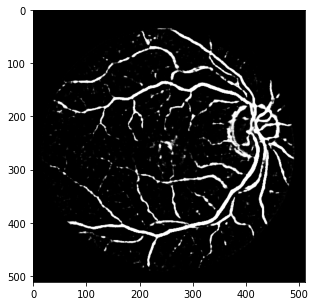

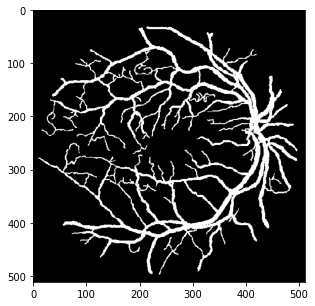

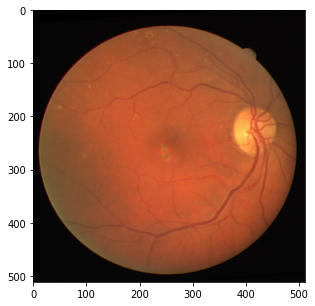

In [10]:
n = 11
# show(decs[n, 1, :, :])
# show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(decs[n, :, :])
show(train_masks[n, :, :])
show(train_images[n, :, :, :])

In [12]:
# Jaccard and Dice
#
# pr = 1.0 * (decs > 1.5*decs.mean()).flatten()
pr = 1.0 * (decs > 0.5).flatten()
tg = train_masks.flatten()
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

0.531448962758388 0.6940472398128923


In [ ]:
# nl = LocallyNonlinear(
#     neighbor_radius = [0, 1, 1, 2, 2, 2, 3, 3, 3, 3],
#     dilation        = [1, 1, 2, 1, 2, 3, 1, 2, 3, 4],
#     degree=1, ochannel=8, drout=0.1)

# Ep: 200, Secs: 63, loss: 0.6629
# Best loss is 0.6624.
# 0.5306511087219228 0.6933665101056383
# Finished in 1429 seconds.